# Importations

In [ ]:
import os
import json
import pandas as pd
import torch
import random
import httpx
import time
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from langchain import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_mistralai import ChatMistralAI
from langchain_community.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from typing import Optional
import numpy as np


## Setting up the environment

In [ ]:
import os
 mistral_api_key = os.environ.get('MISTRAL_API_KEY')

# Loading email test cases
The test cases included various scenarios to evaluate the prompt's effectiveness in different contexts. These included:
* Basic Signature: Emails with complete signature details (name, title, company, etc.).
* Partial Signature: Emails with incomplete signatures, missing one or more elements.
* No Signature: Emails that do not contain any signature information.
* Signatures: Emails with additional formatting or multiple contact details.
* Nested Signatures: Emails with signatures embedded in quoted text from previous conversations.

The rationale for selecting these test cases was to ensure that the prompt could handle a wide variety of real-world email scenarios, from simple to complex. This helped in assessing the robustness and adaptability of the language models.

In [ ]:
# Load test cases from a JSON file

def load_test_cases(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)


In [ ]:
test_cases = load_test_cases("test_cases_data.json")

In [ ]:
test_cases[10]

{'email_content': 'Dear all,  I have updated the project plan. Please review and provide your feedback. The updated plan includes revised timelines and additional resources allocated to the project. Your insights and suggestions will be invaluable in ensuring the plan is comprehensive and achievable.  Best, Lauren Adams Project Coordinator ABC Corp. Phone: +1 (555) 321-9876 Email: lauren.adams@abccorp.com',
 'expected_output': {'name': 'Lauren Adams',
  'email': 'lauren.adams@abccorp.com',
  'job_title': 'Project Coordinator',
  'company': 'ABC Corp.',
  'phone': '+1 (555) 321-9876'}}

## Initial Prompt
The initial prompt was designed to extract key information from email signatures and format it into a structured JSON output. The prompt template included placeholders for common signature elements such as the name, email, phone number, job title, company, address, website, and social media links. The prompt also specified that fields not present in the email should be omitted from the JSON output.

This prompt provides a clear structure for the LLM to extract signature information. It outlined the desired JSON output format and instructed the model to omit missing fields.

In [ ]:
# Define the prompt template for signature extraction
def build_prompt():
    prompt_template = """
    Extract the signature information from the following email content.
    Return the information in JSON format matching the following structure:
    {{
        "name": "Full Name",
        "email": "email@example.com",
        "phone": "Phone number",
        "job_title": "Job Title",
        "company": "Company Name",
        "address": "Full Address",
        "website": "Website URL",
        "social_media": {{
            "linkedin": "LinkedIn URL",
            "twitter": "Twitter handle",
            // other social media
        }}
    }}

    If a field is not present in the email, omit it from the JSON.

    Email content:{email_content}

    Extracted signature information:
    """
    # Use double curly braces to escape the curly braces in the JSON structure
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["email_content"]
    )

    return prompt

# initializing the MIstral AI Model

In [ ]:
def llm(model="mistral-large-latest"):
    return ChatMistralAI(model=model, temperature=0, api_key=MISTRAL_API_KEY)

In [ ]:
# Function to extract signature using Mistral AI with retry logic
def extract_signature_mistral(email_content: str, model="mistral-large-latest", max_retries=100):
    prompt = build_prompt()
    mistral_llm = llm(model)
    chain = LLMChain(llm=mistral_llm, prompt=prompt)

    for attempt in range(max_retries):
        try:
            result = chain.run(email_content=email_content)
            return result
        except httpx.HTTPStatusError as e:
            if e.response.status_code == 429:
                wait_time = 2 ** attempt + random.uniform(0, 1)
                print(f"Rate limit exceeded. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                raise

    raise Exception("Max retries exceeded")

In [ ]:
#To show the progress
def map_progress(pool, seq, f):
    results = []
    with tqdm(total=len(seq)) as progress:
        futures = []
        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)
        for future in futures:
            result = future.result()
            results.append(result)
    return results

In [ ]:
# Function to clean and parse json output
def clean_and_parse_json(raw_output):
    try:
        # Remove code block markers if present
        if raw_output.startswith("```") and raw_output.endswith("```"):
            raw_output = raw_output.strip("```").strip()
        # Attempt to clean up and parse the raw output as JSON
        start_index = raw_output.find('{')
        end_index = raw_output.rfind('}') + 1
        json_str = raw_output[start_index:end_index]
        return json.loads(json_str)
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        return None

## Extracting data using mistral-large-latest model

In [ ]:
# Dictionary to store extracted signatures
extracted_signatures = {}

# Process each email in the ground truth data
for i, rec in enumerate(tqdm(test_cases)):
    if i in extracted_signatures:
        continue

    original_email = rec['email_content']
    try:
        extracted_signature = extract_signature_mistral(original_email)
    except Exception as e:
        print(f"Failed to extract signature for email {i}: {str(e)}")
        continue

    # Print the raw output for debugging
    print(f"Raw output for email {i}: {extracted_signature}")

    signature_json = clean_and_parse_json(extracted_signature)

    if signature_json is None:
        print(f"Warning: Could not parse JSON for email {i}. Storing as string.")
        signature_json = extracted_signature

    extracted_signatures[i] = {
        'original_email': original_email,
        'expected_output': rec['expected_output'],
        'extracted_signature': signature_json
    }

    # Save intermediate results
    with open('mistral_data.json', 'w') as f:
        json.dump(extracted_signatures, f, indent=2)

  0%|          | 0/78 [00:00<?, ?it/s]

Raw output for email 0: ```json
{
    "name": "Sara"
}
```
Rate limit exceeded. Retrying in 1.29 seconds...
Raw output for email 1: ```json
{
    "name": "Michael Brown",
    "email": "michael.brown@xyzsolutions.com",
    "job_title": "Project Manager",
    "company": "XYZ Solutions"
}
```
Raw output for email 2: ```json
{
    "name": "Kevin Lee",
    "job_title": "Senior Developer",
    "phone": "(555) 987-6543"
}
```
Raw output for email 3: ```json
{
    "name": "Emily Rogers",
    "email": "emily.rogers@marketingco.com",
    "job_title": "Marketing Specialist",
    "company": "MarketingCo"
}
```
Raw output for email 4: ```json
{
    "name": "Alan"
}
```
Raw output for email 5: ```json
{
    "name": "Customer Service Team",
    "email": "support@shoponline.com",
    "company": "ShopOnline Inc.",
    "website": "www.shoponline.com"
}
```
Raw output for email 6: ```json
{
    "name": "John"
}
```
Raw output for email 7: ```json
{
    "name": "Rebecca White",
    "email": "rebecca.white

In [ ]:
# Converting into a dataframe
df_mistral = pd.DataFrame(extracted_signatures).T


In [ ]:
df_mistral.tail()

,original_email,expected_output,extracted_signature
73,"Hi all, As we approach the end of the quarter...",{'name': 'Jennifer'},{'name': 'Jennifer'}
74,"Hello Mr. Brown, I hope you are doing well. I...","{'name': 'Alex Turner', 'email': 'alex.turner@...","{'name': 'Alex Turner', 'email': 'alex.turner@..."
75,"Dear Parents, We are thrilled to announce our...","{'name': 'Mrs. Linda Johnson', 'email': 'linda...","{'name': 'Mrs. Linda Johnson', 'email': 'linda..."
76,"Hi Team, I hope this email finds you well. As...",{'name': 'Tom'},{'name': 'Tom'}
77,"Hello Alice, I hope you are having a great da...",{'name': 'Robert'},{'name': 'Robert'}


# Saving the extracted Data

In [ ]:
# Create 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save to CSV
df_mistral.to_csv('data/results-mistral.csv', index=False)

# open-mistral-nemo

In [ ]:
# Defining the model
def llm(model="open-mistral-nemo"):
    return ChatMistralAI(model=model, temperature=0, api_key=MISTRAL_API_KEY)

In [ ]:
def extract_signature_nemo(email_content: str, model="open-mistral-nemo", max_retries=100):
    prompt = build_prompt()
    mistral_llm = llm(model)
    chain = LLMChain(llm=mistral_llm, prompt=prompt)

    for attempt in range(max_retries):
        try:
            result = chain.run(email_content=email_content)
            return result
        except httpx.HTTPStatusError as e:
            if e.response.status_code == 429:
                wait_time = 2 ** attempt + random.uniform(0, 1)
                print(f"Rate limit exceeded. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                raise

    raise Exception("Max retries exceeded")

In [ ]:
# Dictionary to store extracted signatures
extracted_signatures = {}

# Process each email in the ground truth data
for i, rec in enumerate(tqdm(test_cases)):
    if i in extracted_signatures:
        continue

    original_email = rec['email_content']
    try:
        extracted_signature = extract_signature_nemo(original_email)
    except Exception as e:
        print(f"Failed to extract signature for email {i}: {str(e)}")
        continue

    # Print the raw output for debugging
    print(f"Raw output for email {i}: {extracted_signature}")

    # Try to clean up and parse the extracted signature as JSON
    signature_json = clean_and_parse_json(extracted_signature)

    if signature_json is None:
        print(f"Warning: Could not parse JSON for email {i}. Storing as string.")
        signature_json = extracted_signature

    extracted_signatures[i] = {
        'original_email': original_email,
        'expected_output': rec['expected_output'],
        'extracted_signature': signature_json
    }

    # Save intermediate results after each successful extraction
    with open('nemo_extracted_data.json', 'w') as f:
        json.dump(extracted_signatures, f, indent=2)

  0%|          | 0/78 [00:00<?, ?it/s]

Raw output for email 0: {
  "name": "Sara",
  "email": "sara@example.com"
}
Raw output for email 1: {
  "name": "Michael Brown",
  "email": "michael.brown@xyzsolutions.com",
  "job_title": "Project Manager",
  "company": "XYZ Solutions"
}
Raw output for email 2: {
  "name": "Kevin Lee",
  "email": "kevin.lee@example.com", // Assuming the email is the same as the sender's email
  "phone": "(555) 987-6543",
  "job_title": "Senior Developer",
  "company": "", // Not provided in the email content
  "address": "", // Not provided in the email content
  "website": "", // Not provided in the email content
  "social_media": {} // Not provided in the email content
}
Error parsing JSON: Expecting property name enclosed in double quotes: line 3 column 37 (char 61)
Raw output for email 3: {
  "name": "Emily Rogers",
  "email": "emily.rogers@marketingco.com",
  "job_title": "Marketing Specialist",
  "company": "MarketingCo"
}
Raw output for email 4: Based on the provided email content, here's the e

In [ ]:
df_nemo = pd.DataFrame(extracted_signatures).T


In [ ]:
df_nemo.head()

,original_email,expected_output,extracted_signature
0,"Hi team, Please find attached the monthly rep...",{'name': 'Sara'},"{'name': 'Sara', 'email': 'sara@example.com'}"
1,"Dear Team, This is a reminder for our upcomin...","{'name': 'Michael Brown', 'email': 'michael.br...","{'name': 'Michael Brown', 'email': 'michael.br..."
2,"Hi everyone, Just a quick note to let you kno...","{'name': 'Kevin Lee', 'job_title': 'Senior Dev...","{\n ""name"": ""Kevin Lee"",\n ""email"": ""kevin.l..."
3,"Hello, Thank you for your interest in our ser...","{'name': 'Emily Rogers', 'email': 'emily.roger...","{'name': 'Emily Rogers', 'email': 'emily.roger..."
4,"Hi, Can you please send me the latest sales f...",{'name': 'Alan'},"{'name': 'Alan', 'email': 'alan@example.com', ..."


In [ ]:
# Save to CSV
df_nemo.to_csv('data/results-nemo.csv', index=False)

# Cosine Similarity

The evaluation is based on cosine similarity between the extracted data and reference signatures i.e the expected output.
Cosine similarity measures the similarity between two vectors, in this case, it compares the extracted email signatures with the expected outputs. A higher cosine similarity indicates a better match between the extracted and expected information.
## How it works:
Text Conversion: Both the extracted signature and the expected signature are converted into numerical representations (vectors).The sentence_transformers library is used to convert text into numerical embeddings.
Cosine similarity is calculated as the dot product of the normalized vectors. A value closer to 1 indicates a higher similarity between the two signatures, while a value closer to 0 indicates lower similarity.
Essentially, a higher cosine similarity score means the LLM did a better job of extracting the correct information from the email.

In [ ]:
# Initialize SentenceTransformer model for encoding the data
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [ ]:
answer_orig = "Hi,  I'm confirming our lunch meeting for tomorrow at 1 PM."
answer_llm = 'Hello, I will be joining you for lunch today'

# Encoding to convert into vectors
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

# cosine similarity is the dot product of normalized vectors
v_llm.dot(v_orig)

0.69777757

# Evaluating mistral-large-latest using Cosine Similarity

In [ ]:
results_mistral = df_mistral.to_dict(orient='records')

In [ ]:
record = results_mistral[0]

In [ ]:
record


{'original_email': "Hi team,  Please find attached the monthly report. It contains a detailed breakdown of our performance metrics, sales figures, and key accomplishments for the month. I've also included some insights and recommendations based on the data.  Let me know if you have any questions or need further clarification on any of the points mentioned.  Best, Sara",
 'expected_output': {'name': 'Sara'},
 'extracted_signature': {'name': 'Sara'}}

In [ ]:
answer_llm = record['extracted_signature']
answer_llm

{'name': 'Sara'}

In [ ]:
# Function to compute cosine similarity
def compute_similarity(record):
    answer_orig = str(record['expected_output'])
    answer_llm = str(record['extracted_signature'])

    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    # Cosine similarity is the dot product of normalized vectors
    similarity = (v_llm @ v_orig) / (np.linalg.norm(v_llm) * np.linalg.norm(v_orig))
    return similarity

In [ ]:
# Compute similarities fr mistral results
similarity = []

for record in tqdm(results_mistral):
    sim = compute_similarity(record)
    similarity.append(sim)



  0%|          | 0/78 [00:00<?, ?it/s]

In [ ]:
# Print similarities
print(similarity)

[1.0000001, 1.0, 1.0, 1.0, 1.0, 0.9485954, 1.0000001, 1.0, 1.0, 1.0, 0.9912981, 1.0, 1.0, 1.0, 1.0000001, 0.9958598, 1.0, 1.0, 0.9569477, 1.0, 0.96270156, 1.0, 0.9985226, 1.0, 1.0, 0.95481586, 1.0, 1.0, 0.92766374, 1.0000001, 1.0, 0.99651295, 1.0000001, 1.0, 0.95577824, 1.0, 0.963767, 1.0, 0.99582475, 1.0, 1.0, 0.3676394, 1.0, 0.9966764, 1.0, 1.0, 0.97014374, 1.0, 0.957134, 1.0000001, 0.9973844, 1.0, 1.0, 0.9603517, 1.0000001, 1.0, 0.94665635, 0.9415366, 1.0, 0.96470666, 1.0000001, 0.97363734, 1.0, 1.0000001, 1.0, 1.0, 1.0, 1.0, 1.0, 0.48854196, 0.9471338, 0.9493612, 1.0000001, 1.0, 1.0000001, 1.0, 1.0, 1.0]


In [ ]:
df_mistral['cosine'] = similarity
df_mistral['cosine'].describe()

count    78.000000
mean      0.975759
std       0.091883
min       0.367639
25%       0.995834
50%       1.000000
75%       1.000000
max       1.000000
Name: cosine, dtype: float64

Mistral Large latest model has :a higher average cosine similarity and lower standard deviation, indicating greater accuracy and consistency.

# Evaluating open-mistral-nemo using cosine Similarity



In [ ]:
results_nemo = df_nemo.to_dict(orient='records')

similarity_nemo = []

for record in tqdm(results_nemo):
    sim = compute_similarity(record)
    similarity_nemo.append(sim)

  0%|          | 0/78 [00:00<?, ?it/s]

In [ ]:
df_nemo['cosine'] = similarity_nemo
df_nemo['cosine'].describe()

count    78.000000
mean      0.863052
std       0.212798
min       0.189032
25%       0.753275
50%       0.971493
75%       1.000000
max       1.000000
Name: cosine, dtype: float64

Based on these results, Mistral-large-latest demonstrated superior performance with a higher average cosine similarity and lower standard deviation, indicating greater accuracy and consistency.

In [ ]:
df_nemo.head(10)

,original_email,expected_output,extracted_signature,cosine
0,"Hi team, Please find attached the monthly rep...",{'name': 'Sara'},"{'name': 'Sara', 'email': 'sara@example.com'}",0.780013
1,"Dear Team, This is a reminder for our upcomin...","{'name': 'Michael Brown', 'email': 'michael.br...","{'name': 'Michael Brown', 'email': 'michael.br...",1.000000
2,"Hi everyone, Just a quick note to let you kno...","{'name': 'Kevin Lee', 'job_title': 'Senior Dev...","{\n ""name"": ""Kevin Lee"",\n ""email"": ""kevin.l...",0.585488
3,"Hello, Thank you for your interest in our ser...","{'name': 'Emily Rogers', 'email': 'emily.roger...","{'name': 'Emily Rogers', 'email': 'emily.roger...",1.000000
4,"Hi, Can you please send me the latest sales f...",{'name': 'Alan'},"{'name': 'Alan', 'email': 'alan@example.com', ...",0.590995
5,"Dear Customer, Your order has been shipped an...","{'email': 'support@shoponline.com', 'company':...","{'name': 'Customer Service Team', 'email': 'su...",0.948595
6,"Hey, I'll be joining the team call today at 3...",{'name': 'John'},{'name': 'John'},1.000000
7,"Dear Alice, Thank you for reaching out. I hav...","{'name': 'Rebecca White', 'email': 'rebecca.wh...","{'name': 'Rebecca White', 'email': 'rebecca.wh...",1.000000
8,"Hi, I'm confirming our lunch meeting for tomo...",{'name': 'David'},"{'name': 'David', 'email': 'not provided', 'ph...",0.535015
9,"Hello, Please review the attached document an...","{'name': 'Nina Thompson', 'email': 'nina.thomp...","{'name': 'Nina Thompson', 'email': 'nina.thomp...",1.000000


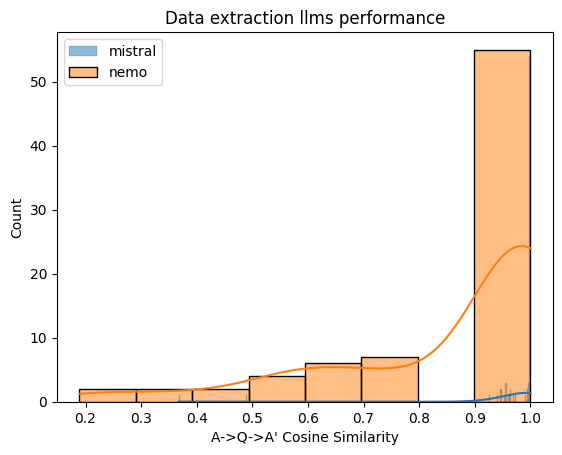

In [ ]:
# sns.distplot(df_mistral['cosine'], label='mistral')
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_mistral['cosine'], label='mistral', kde=True)
sns.histplot(df_nemo['cosine'], label='nemo', kde=True)

plt.title("Data extraction llms performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

# Prompt Iteration
The initial prompt was refined to provide examples and further clarify the expected output format. The updated prompt included:

* Specific examples of email content and corresponding extracted signatures.
* Clarification on how to handle missing information in the signature, in which it should be ommitted from the output.

The addition of examples aimed to provide the model with a clearer understanding of the expected output structure, improving the accuracy of the extracted information, especially in more complex cases.

In [ ]:
def build_prompt():
    prompt_template = """
    Extract the signature information from the following email content.
    Return the information in JSON format matching the following structure:
    {{
        "name": "Full Name",
        "email": "email@example.com",
        "phone": "Phone number",
        "job_title": "Job Title",
        "company": "Company Name",
        "address": "Full Address",
        "website": "Website URL",
        "social_media": {{
            "linkedin": "LinkedIn URL",
            "twitter": "Twitter handle",
            // other social media
        }}
    }}

    If a field is not present in the email, omit it from the JSON.

    Examples:
    Email content: "Best, John Doe"
    Extracted signature information: {{
        "name": "John Doe"
    }}

    Email content: "Best regards, Michael Brown Project Manager XYZ Solutions michael.brown@xyzsolutions.com"
    Extracted signature information: {{
        "name": "Michael Brown",
        "email": "michael.brown@xyzsolutions.com",
        "job_title": "Project Manager",
        "company": "XYZ Solutions"
    }}

    Email content: "Cheers, Kevin Lee Senior Developer (555) 987-6543"
    Extracted signature information: {{
        "name": "Kevin Lee",
        "job_title": "Senior Developer",
        "phone": "(555) 987-6543"
    }}

    Email content: "Sincerely, Emily Rogers Marketing Specialist emily.rogers@marketingco.com MarketingCo"
    Extracted signature information: {{
        "name": "Emily Rogers",
        "email": "emily.rogers@marketingco.com",
        "job_title": "Marketing Specialist",
        "company": "MarketingCo"
    }}

    Email content:{email_content}

    Extracted signature information:
    """
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["email_content"]
    )

    return prompt


# Extracting data using mistral-large-latest model After Iteration

In [ ]:
# Dictionary to store extracted signatures
extracted_signatures = {}

# Process each email in the ground truth data
for i, rec in enumerate(tqdm(test_cases)):
    if i in extracted_signatures:
        continue

    original_email = rec['email_content']
    try:
        extracted_signature = extract_signature_mistral(original_email)
    except Exception as e:
        print(f"Failed to extract signature for email {i}: {str(e)}")
        continue

    # Print the raw output for debugging
    print(f"Raw output for email {i}: {extracted_signature}")

    # Try to clean up and parse the extracted signature as JSON
    signature_json = clean_and_parse_json(extracted_signature)

    if signature_json is None:
        print(f"Warning: Could not parse JSON for email {i}. Storing as string.")
        signature_json = extracted_signature

    extracted_signatures[i] = {
        'original_email': original_email,
        'expected_output': rec['expected_output'],
        'extracted_signature': signature_json
    }

    # Save intermediate results after each successful extraction
    with open('mistral_data_after_iteration.json', 'w') as f:
        json.dump(extracted_signatures, f, indent=2)

  0%|          | 0/78 [00:00<?, ?it/s]

Raw output for email 0: ```json
{
    "name": "Sara"
}
```
Raw output for email 1: ```json
{
    "name": "Michael Brown",
    "email": "michael.brown@xyzsolutions.com",
    "job_title": "Project Manager",
    "company": "XYZ Solutions"
}
```
Raw output for email 2: ```json
{
    "name": "Kevin Lee",
    "job_title": "Senior Developer",
    "phone": "(555) 987-6543"
}
```
Raw output for email 3: ```json
{
    "name": "Emily Rogers",
    "email": "emily.rogers@marketingco.com",
    "job_title": "Marketing Specialist",
    "company": "MarketingCo"
}
```
Raw output for email 4: ```json
{
    "name": "Alan"
}
```
Raw output for email 5: ```json
{
    "name": "Customer Service Team",
    "email": "support@shoponline.com",
    "company": "ShopOnline Inc.",
    "website": "www.shoponline.com"
}
```
Raw output for email 6: ```json
{
    "name": "John"
}
```
Raw output for email 7: ```json
{
    "name": "Rebecca White",
    "email": "rebecca.white@salescorp.com",
    "job_title": "Sales Manager"

In [ ]:
df_mistral_after_iteration = pd.DataFrame(extracted_signatures).T
# Save to CSV
df_mistral_after_iteration.to_csv('data/df_mistral_after_Iteration.csv', index=False)

In [ ]:
df_mistral_after_iteration.head()

,original_email,expected_output,extracted_signature
0,"Hi team, Please find attached the monthly rep...",{'name': 'Sara'},{'name': 'Sara'}
1,"Dear Team, This is a reminder for our upcomin...","{'name': 'Michael Brown', 'email': 'michael.br...","{'name': 'Michael Brown', 'email': 'michael.br..."
2,"Hi everyone, Just a quick note to let you kno...","{'name': 'Kevin Lee', 'job_title': 'Senior Dev...","{'name': 'Kevin Lee', 'job_title': 'Senior Dev..."
3,"Hello, Thank you for your interest in our ser...","{'name': 'Emily Rogers', 'email': 'emily.roger...","{'name': 'Emily Rogers', 'email': 'emily.roger..."
4,"Hi, Can you please send me the latest sales f...",{'name': 'Alan'},{'name': 'Alan'}


# Evaluation of open-mistral-nemo after iteration

In [ ]:
# Dictionary to store extracted signatures
extracted_signatures = {}

# Process each email in the ground truth data
for i, rec in enumerate(tqdm(test_cases)):
    if i in extracted_signatures:
        continue

    original_email = rec['email_content']
    try:
        extracted_signature = extract_signature_nemo(original_email)
    except Exception as e:
        print(f"Failed to extract signature for email {i}: {str(e)}")
        continue

    # Print the raw output for debugging
    print(f"Raw output for email {i}: {extracted_signature}")

    # Try to clean up and parse the extracted signature as JSON
    signature_json = clean_and_parse_json(extracted_signature)

    if signature_json is None:
        print(f"Warning: Could not parse JSON for email {i}. Storing as string.")
        signature_json = extracted_signature

    extracted_signatures[i] = {
        'original_email': original_email,
        'expected_output': rec['expected_output'],
        'extracted_signature': signature_json
    }

    # Save intermediate results after each successful extraction
    with open('nemo_extracted_data_after_iteration.json', 'w') as f:
        json.dump(extracted_signatures, f, indent=2)

  0%|          | 0/78 [00:00<?, ?it/s]

Raw output for email 0: Based on the provided email content, here's the extracted signature information in JSON format:

```json
{
  "name": "Sara"
}
```
Rate limit exceeded. Retrying in 1.10 seconds...
Raw output for email 1: {
  "name": "Michael Brown",
  "email": "michael.brown@xyzsolutions.com",
  "job_title": "Project Manager",
  "company": "XYZ Solutions"
}
Raw output for email 2: {
  "name": "Kevin Lee",
  "job_title": "Senior Developer",
  "phone": "(555) 987-6543"
}
Raw output for email 3: {
  "name": "Emily Rogers",
  "email": "emily.rogers@marketingco.com",
  "job_title": "Marketing Specialist",
  "company": "MarketingCo"
}
Raw output for email 4: Based on the provided email content, here's the extracted signature information in JSON format:

```json
{
  "name": "Alan"
}
```
Rate limit exceeded. Retrying in 1.75 seconds...
Raw output for email 5: {
  "name": "Customer Service Team",
  "email": "support@shoponline.com",
  "company": "ShopOnline Inc.",
  "website": "www.shopon

In [ ]:
df_nemo_after_iteration = pd.DataFrame(extracted_signatures).T


In [ ]:
df_nemo_after_iteration.head()

,original_email,expected_output,extracted_signature
0,"Hi team, Please find attached the monthly rep...",{'name': 'Sara'},{'name': 'Sara'}
1,"Dear Team, This is a reminder for our upcomin...","{'name': 'Michael Brown', 'email': 'michael.br...","{'name': 'Michael Brown', 'email': 'michael.br..."
2,"Hi everyone, Just a quick note to let you kno...","{'name': 'Kevin Lee', 'job_title': 'Senior Dev...","{'name': 'Kevin Lee', 'job_title': 'Senior Dev..."
3,"Hello, Thank you for your interest in our ser...","{'name': 'Emily Rogers', 'email': 'emily.roger...","{'name': 'Emily Rogers', 'email': 'emily.roger..."
4,"Hi, Can you please send me the latest sales f...",{'name': 'Alan'},{'name': 'Alan'}


In [ ]:
# Save to CSV
df_nemo_after_iteration.to_csv('data/results-nemo_after_iteration.csv', index=False)

#Evaluation of mistral-large-latest model After Prompt Iteration Evaluation

In [ ]:
results_mistral_iter = df_mistral_after_iteration.to_dict(orient='records')

similarity_mistral_iter = []

for record in tqdm(results_mistral_iter):
    sim = compute_similarity(record)
    similarity_mistral_iter.append(sim)

  0%|          | 0/78 [00:00<?, ?it/s]

In [ ]:

df_mistral_after_iteration['cosine'] = similarity_mistral_iter
df_mistral_after_iteration['cosine'].describe()

count    78.000000
mean      0.990927
std       0.018777
min       0.927664
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: cosine, dtype: float64

The mean score improved from 0.976 to 0.991, indicating that the overall accuracy of the extracted signatures improved with the refined prompt.

In addition, The standard deviation decreased from 0.092 to 0.019, showing that the performance became more consistent after prompt improvement.

The minimum score increased from 0.368 to 0.928, which means the lowest performing cases improved significantly.

The improvements to the prompt, including additional examples, have significantly enhanced the performance of the model. The reduced variability and increased mean score suggest that the refined prompt leads to more accurate and consistent extraction of signature information.

In [ ]:
results_nemo_iter = df_nemo_after_iteration.to_dict(orient='records')

similarity_nemo_iter = []

for record in tqdm(results_nemo_iter):
    sim = compute_similarity(record)
    similarity_nemo_iter.append(sim)

  0%|          | 0/78 [00:00<?, ?it/s]

In [ ]:

df_nemo_after_iteration['cosine'] = similarity_nemo_iter
df_nemo_after_iteration['cosine'].describe()

count    78.000000
mean      0.882481
std       0.229348
min       0.257969
25%       0.948787
50%       1.000000
75%       1.000000
max       1.000000
Name: cosine, dtype: float64

The mean score improved from 0.863 to 0.882, indicating an enhancement in overall performance after prompt refinement.


After adding examples to the prompt, the open-mistral-nemo model showed improved average performance and higher minimum scores. .

In [ ]:
df_nemo_after_iteration.to_csv('data/nemo_after_iteration.csv', index=False)
df_mistral_after_iteration.to_csv('data/mistral_after_iteration.csv', index=False)

<ipython-input-133-2b2b588071d3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_mistral_after_iteration['cosine'], label='mistral')
<ipython-input-133-2b2b588071d3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_nemo_after_iteration['cosine'], label='nemo')


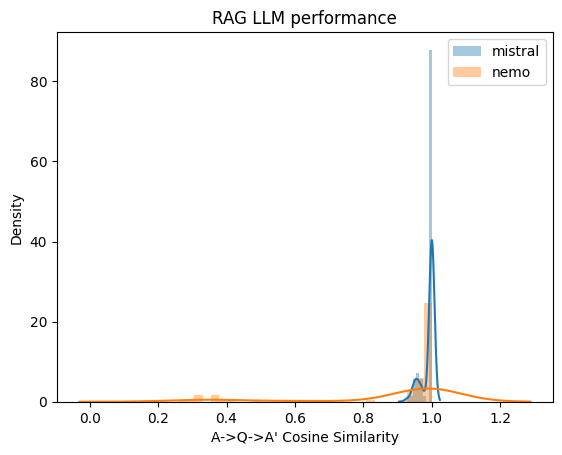

In [ ]:
# sns.distplot(df_mistral['cosine'], label='mistral')
import seaborn as sns

sns.histplot(df_mistral_after_iteration['cosine'], label='mistral')
sns.histplot(df_nemo_after_iteration['cosine'], label='nemo')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

# Conclusion
The second prompt iteration showed a significant improvement in performance, especially for the Mistral-Large-Latest model. The mean cosine similarity increased, and the standard deviation decreased, indicating more consistent and accurate extractions. The use of examples in the prompt helped the models better understand the expected format and content, leading to fewer errors and more accurate extractions.

Overall, the iterative approach to prompt engineering, with careful evaluation and adjustment, led to a more robust and effective solution for extracting email signature information. The final results demonstrated the effectiveness of the refined prompt in handling a wide range of email signature scenarios.